## Setup

### The necessary libraries

In [1]:
import time
import pandas as pd
from tqdm.auto import tqdm
from itertools import repeat

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Allow for import of dataloader from pdf_extraction folder
import os
import sys

module_path = os.path.abspath(os.path.join("../04_dataset_access/"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
%load_ext autoreload
%autoreload 2
import evaluation
from dataloader import Dataloader # type: ignore
import topic_models
from topic_models import nmf_pipeline, lda_pipeline

### Getting the dataset

In [4]:
df = pd.read_csv(
    "../24212003_requirements_for_artificial_intelligence/patched_feedbacks.csv"
)
df = Dataloader("page", full=True).from_folder(
    "../24212003_requirements_for_artificial_intelligence/attachments/", df
)

df["tokenized_text"] = df["tokenized"].map(lambda x: x[0] if x is not None else None)
df["tokenized_lemmas"] = df["tokenized"].map(lambda x: x[1] if x is not None else None)
df["tokenized"] = df["tokenized"].map(
    lambda x: [t for t in x[1] if t is not None] if x is not None else None
)
df["page"] = df.groupby("id").cumcount()

df, all = df.query("language_detected == 'en' and tokenized.str.len() > 0").copy(), df

assert len(all) == 2282 + 299 - 13
all.head()

As n_jobs=-1 <= 0, enabling multiprocessing with 24 cores!
As n_jobs=-1 <= 0, enabling multiprocessing with 24 cores!


,id,text,language,country,user_type,organization,surname,feedback,status,company_size,...,tr_number,scope,governance_level,full_name,source,language_detected,tokenized,tokenized_text,tokenized_lemmas,page
0,2665651,Equinet welcomes the opportunity to provide co...,en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,NaN,NaN,NaN,NaN,feedback,en,"[equinet, welcome, the, opportunity, to, provi...","[Equinet , welcomes , the , opportunity , to ,...","[equinet, welcome, the, opportunity, to, provi...",0
1,2665651,Equinet’s feedback to the European Commission'...,en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,NaN,NaN,NaN,NaN,attachment,en,"[equinet, feedback, to, the, european, commiss...","[Equinet, ’s , feedback , to , the , European ...","[equinet, None, feedback, to, the, european, c...",1
2,2665651,"equality bodies, alongside with other sectoral...",en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,NaN,NaN,NaN,NaN,attachment,en,"[equality, body, alongside, with, other, secto...","[equality , bodies, , , alongside , with , oth...","[equality, body, None, alongside, with, other,...",2
3,2665651,investment in 1) digital literacy for those wh...,en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,NaN,NaN,NaN,NaN,attachment,en,"[investment, in, 1, digital, literacy, for, th...","[investment , in , 1, ) , digital , literacy ,...","[investment, in, 1, None, digital, literacy, f...",3
4,2665651,4. Require equality and human rights impact as...,en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,NaN,NaN,NaN,NaN,attachment,en,"[4, require, equality, and, human, right, impa...","[4, . , Require , equality , and , human , rig...","[4, None, require, equality, and, human, right...",4


In [5]:
all["language_detected"].value_counts(
    normalize=True, dropna=False
)

en    0.901480
de    0.032710
fr    0.029984
pl    0.019081
es    0.004673
el    0.003505
pt    0.003115
sv    0.002336
nl    0.001947
it    0.000389
ru    0.000389
bg    0.000389
Name: language_detected, dtype: float64

In [6]:
all["tokenized"].str.len().describe()

count    2315.000000
mean      400.852268
std       177.720775
min         0.000000
25%       308.500000
50%       426.000000
75%       514.500000
max      1056.000000
Name: tokenized, dtype: float64

## Optimal number of topics


#### Step 1: LDA hyperparameter tuning

In [7]:
lda_hyperparameters = topic_models.hyperparameter_tune(
    df,
    lda_pipeline,
    "lda",
    use_cv=True,
    scorer=evaluation.compute_perplexity_from_pipeline,
)

Existing hyperparameter tuning for pipeline lda found, continuing there. You can force the use your (or the default) hyperparameter by setting overwrite=True.


  0%|          | 0/735 [00:00<?, ?it/s]

In [8]:
n_topics = [5, 7, 10, 12, 15, 17, 20, 22, 25, 27, 30, 32, 35, 37, 40, 42, 45, 47, 50]
grid = {
    "topic_model__doc_topic_prior": [None, 0.001, 0.005, 0.01, 0.05, 0.1],
    "topic_model__n_components": n_topics,
    "topic_model__topic_word_prior": [0.5, 1, 2.5, 3.5, 5, 6.5, 8.5, 10],
}

lda_hyperparameters_2 = topic_models.hyperparameter_tune(
    df,
    lda_pipeline,
    "lda_2",
    hyperparameter_grid=grid,
    use_cv=True,
    scorer=evaluation.compute_perplexity_from_pipeline,
)

Existing hyperparameter tuning for pipeline lda_2 found, continuing there. You can force the use your (or the default) hyperparameter by setting overwrite=True.


  0%|          | 0/912 [00:00<?, ?it/s]

In [9]:
combined = pd.concat((lda_hyperparameters, lda_hyperparameters_2)).sort_values("score")
combined = combined.drop_duplicates(
    [
        "topic_model__doc_topic_prior",
        "topic_model__n_components",
        "topic_model__topic_word_prior",
    ]
)

### Step 2: Evaluating topic coherence for various number of topics

In [10]:
grouped = combined.groupby(["topic_model__n_components"])
best = grouped.apply(lambda df: df[df["score"] == df["score"].min()].iloc[0]).reset_index(
    drop=True
)
hyperparameter_grid = best.loc[:, best.columns != "score"].to_dict("records")

best.query("topic_model__n_components.isin([15, 20])")

,topic_model__doc_topic_prior,topic_model__n_components,topic_model__topic_word_prior,score
8,0.05,15,0.5,1388.780385
10,0.05,20,0.5,1487.500135


In [11]:
lda_topic = topic_models.hyperparameter_tune(
    df,
    lda_pipeline,
    "lda_topics",
    scorer=evaluation.compute_coherence_from_pipeline,
    hyperparameter_grid=hyperparameter_grid,
)

nmf_topic = topic_models.hyperparameter_tune(df, nmf_pipeline, "nmf_topics")

Existing hyperparameter tuning for pipeline lda_topics found, continuing there. You can force the use your (or the default) hyperparameter by setting overwrite=True.


  0%|          | 0/24 [00:00<?, ?it/s]

Existing hyperparameter tuning for pipeline nmf_topics found, continuing there. You can force the use your (or the default) hyperparameter by setting overwrite=True.


  0%|          | 0/15 [00:00<?, ?it/s]

In [12]:
lda_topic["topic_model"] = "lda"
nmf_topic["topic_model"] = "nmf"
hyperparameters = pd.concat((lda_topic, nmf_topic))
hyperparameters["score"] = hyperparameters["score"].astype("float")

### The results: ~15 topics topics optimal

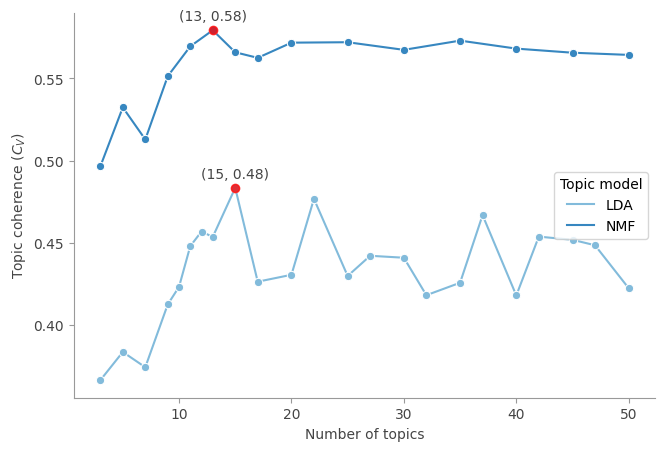

In [13]:
fig, _ = evaluation.plot_coherence_against_topics(hyperparameters)

fig.savefig("images/coherence_against_topics.pdf", bbox_inches="tight")

### Evaluating LDA's failure

In [14]:
opt = combined.query("topic_model__n_components == 20").sort_values("score").iloc[[0]]

if not os.path.isfile("hyperparameter_tuning/lda_max_iter.csv"):
    results = []
    for iter in tqdm([1, 5, 10, 25, 50, 75, 100, 150, 300, 500, 750, 1000]):
        # Extend training to given number of iterations
        lda_pipeline.set_params(**{"topic_model__max_iter": iter})

        start = time.time()
        lda_pipeline, H_lda = topic_models.trained_pipeline_from_hyperparameters(
            lda_pipeline, opt, df, 20
        )
        results.append(
            dict(
                iter=iter,
                score=evaluation.compute_coherence_from_pipeline(
                    lda_pipeline, df["tokenized"]
                ),
                time=time.time() - start,
            )
        )

    results = pd.DataFrame(results)
    results.to_csv("hyperparameter_tuning/lda_max_iter.csv", index=False)

else:
    results = pd.read_csv("hyperparameter_tuning/lda_max_iter.csv")

# Set to 100 to get optimal performance from now on
lda_pipeline.set_params(**{"topic_model__max_iter": 100})

Pipeline(steps=[('vectorizer',
                 CountVectorizer(lowercase=False, min_df=10,
                                 stop_words='english', token_pattern=None,
                                 tokenizer=<function <lambda> at 0x7fa8707f23b0>)),
                ('topic_model',
                 LatentDirichletAllocation(max_iter=100, n_jobs=-1,
                                           random_state=42))])

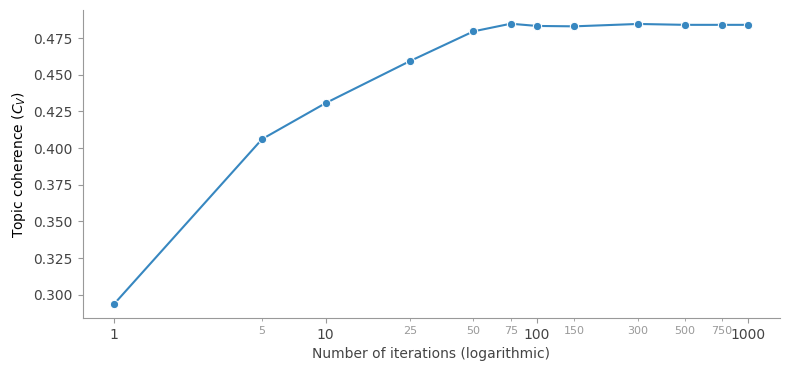

In [15]:
fig, ax = plt.subplots(figsize=(9, 4))

sns.lineplot(
    x="iter",
    y="score",
    data=results,
    color=[0.21568627, 0.52941176, 0.75424837, 1.0],
    style=repeat("", len(results)),
    markers="o",
    dashes=False,
    ax=ax,
)

ax.set_xlabel("Number of iterations (logarithmic)", color="#444444")
ax.set_ylabel("Topic coherence ($C_V$)")

ax.set_xscale("log")
ax.set_xticks([1, 10, 100, 1000], [1, 10, 100, 1000], color="#444444")
ax.set_xticks(results["iter"], results["iter"], minor=True, size=8)

evaluation._theme_plot(ax)
fig.savefig("images/lda_n_iterations.pdf", bbox_inches="tight")

In [16]:
# Timing using a Ryzen 5900X (12 cores) - with less cores the difference can easily
# become an order of magnitude
start = time.time()
nmf_pipeline, H_nmf = topic_models.trained_pipeline_from_hyperparameters(
    nmf_pipeline, nmf_topic, df, 20
)
it = nmf_pipeline.named_steps["topic_model"].n_iter_
print(f"{round(time.time() - start, 2)}s, {it}it.")

start = time.time()
lda_pipeline, H_lda = topic_models.trained_pipeline_from_hyperparameters(
    lda_pipeline, lda_topic, df, 20
)
it = lda_pipeline.named_steps["topic_model"].n_iter_
print(f"{round(time.time() - start, 2)}s, {it}it.")

3.05s, 100it.
9.67s, 100it.


In [17]:
df_2 = df.copy()
n_docs = len(df)
tokens = (
    df_2.reset_index()[["index", "tokenized"]]
    .explode("tokenized")
    .drop_duplicates(subset=["index", "tokenized"])
)
tokens = tokens.groupby("tokenized").count()
common_tokens = tokens.query("index > @n_docs * 0.8").index.to_list()
df_2["tokenized"] = df_2["tokenized"].map(
    lambda tt: [t for t in tt if t not in common_tokens]
)

lda_pipeline, H_lda = topic_models.trained_pipeline_from_hyperparameters(
    lda_pipeline, lda_topic, df_2, 20
)

evaluation.compute_coherence_from_pipeline(lda_pipeline, df_2["tokenized"])

0.5076331536182247

## Evaluation

### Getting the topic terms - NMF edition

In [18]:
nmf_pipeline, H_nmf = topic_models.trained_pipeline_from_hyperparameters(
    nmf_pipeline, nmf_topic, df, 20
)

In [19]:
evaluation.get_topics_from_pipeline(nmf_pipeline)

,topic_00,topic_01,topic_02,topic_03,topic_04,topic_05,topic_06,topic_07,topic_08,topic_09,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,ai,ai,right,model,authority,medical,artificial,customer,biometric,datum,education,attach,person,child,definition,healthcare,attached,consumer,disagree,product
1,risk,europe,fundamental,algorithm,article,device,intelligence,aiaas,recognition,data,etuce,feedback,article,digital,ai,patient,document,credit,agree,standard
2,high,technology,human,ml,national,mdr,european,provider,identification,error,teacher,comment,harm,young,approach,health,file,financial,strongly,conformity
3,use,european,law,explanation,sandbox,ivdr,act,service,emotion,set,tool,thank,prohibit,persuasive,software,professional,comment,creditworthiness,answer,safety
4,user,innovation,proposal,method,member,manufacturer,proposal,processing,use,bias,personnel,opportunity,subliminal,online,technique,epf,position,aia,question,assessment
5,requirement,eu,protection,process,provider,aia,2021,controller,remote,training,academic,act,behaviour,design,regulation,ai,telecom,url,plan,component
6,provider,regulation,individual,explainability,market,regulation,commission,supplementary,space,gdpr,student,response,social,social,annex,care,refer,score,regulation,legislation
7,obligation,development,impact,internal,board,software,lay,cloud,prohibition,testing,intelligence,commission,ai,technology,statistical,datum,feedback,art,sufficiently,standardisation
8,application,regulatory,adm,use,competent,requirement,regulation,chain,surveillance,free,artificial,association,manipulative,people,list,ehds,character,scoring,elaborate,requirement
9,act,global,decision,validation,code,notified,parliament,datum,enforcement,article,trade,consultation,prohibition,parent,propose,digital,response,insurance,concern,specification


### Getting the topic terms - LDA edition

In [20]:
lda_pipeline, H_lda = topic_models.trained_pipeline_from_hyperparameters(
    lda_pipeline, lda_topic, df, 20
)

In [21]:
evaluation.get_topics_from_pipeline(lda_pipeline)

,topic_00,topic_01,topic_02,topic_03,topic_04,topic_05,topic_06,topic_07,topic_08,topic_09,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,social,service,right,ai,ai,eco,use,intelligence,interpretability,ai,consumer,vehicle,datum,person,datum,sme,authority,ai,child,ai
1,scoring,provider,proposal,education,health,child,biometric,artificial,transparency,definition,credit,automotive,model,ai,right,cost,ai,risk,use,regulation
2,trustworthiness,customer,fundamental,use,healthcare,protect,ai,european,concept,regulation,financial,type,use,harm,gdpr,small,national,high,digital,technology
3,treatment,datum,ai,risk,patient,technology,right,commission,explainability,device,risk,car,ai,prohibit,data,company,market,article,social,use
4,score,processing,protection,test,datum,online,law,regulation,file,medical,use,approval,algorithm,influence,personal,sandbox,regulation,use,online,risk
5,natural,aiaas,legal,worker,european,internet,recognition,ai,attached,approach,regulation,manufacturer,bias,behaviour,protection,compliance,member,requirement,people,eu
6,context,chain,human,employment,research,abuse,identification,act,cybersecurity,software,creditworthiness,safety,data,subliminal,adm,business,access,provider,technology,development
7,certain,use,standard,regulation,use,sexual,risk,proposal,document,use,insurance,motor,process,practice,impact,innovation,article,user,design,commission
8,unfavourable,ai,law,tool,digital,allow,enforcement,2021,correlation,propose,service,road,training,cause,fundamental,certification,board,regulation,user,european
9,detrimental,application,individual,right,europe,space,public,eu,threat,annex,institution,traffic,ml,physical,processing,scale,code,assessment,medium,act


### Naming the topics

/tmp/ipykernel_48528/1687314920.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


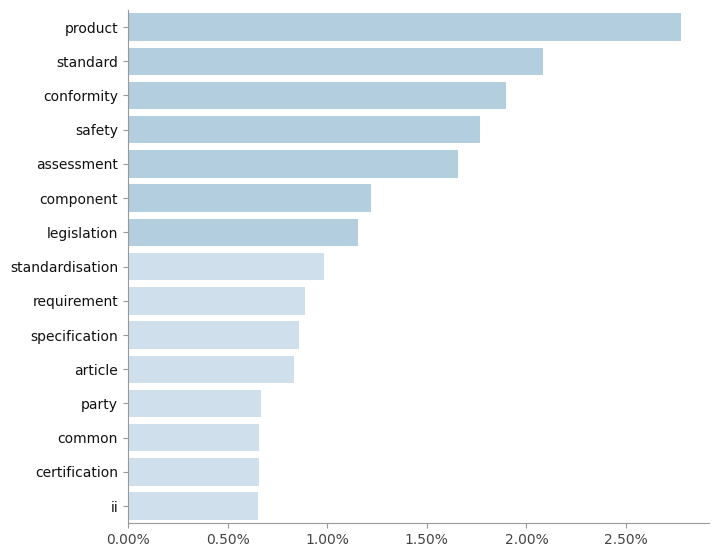

In [22]:
fig, _ = evaluation.plot_topic_terms(nmf_pipeline, 19, n_terms=15)
fig.show()
# fmt: off
nmf_topic_names = [
    "High-risk AI (regulation)",
    "Future of AI development in the EU",
    "Protecting fundamental rights",
    "Models & explainability",
    "NCAs: enforcement & support",
    "Medical devices (& their regulation)",
    "Cover pages",
    "AIaaS",
    "Biometrics",
    "Data (privacy, biases, & quality)",
    "Education",
    "Referencing attachments #2",
    "Manipulative influences",
    "Children",
    "Defining AI",
    "Healthcare",
    "Referencing attachments #1",
    "Financial services & consumer protections",
    "General reactions (CLAIRE)",
    "Assessment of conformity",
]

In [23]:
for i in range(nmf_pipeline.named_steps["topic_model"].n_components):
    fig, ax = evaluation.plot_topic_terms(nmf_pipeline, i, n_terms=15)
    if len(nmf_topic_names) > i:
        ax.set_title(f"Topic '{nmf_topic_names[i]}'")
    fig.savefig(f"images/nmf_topic_{str(i).zfill(2)}.pdf", bbox_inches="tight")
    plt.close(fig)
evaluation.merge_pdfs(
    sorted(
        ["images/" + f for f in os.listdir("images/") if f.startswith("nmf_topic_")]
    ),
    "images/nmf_topics.pdf",
)

/tmp/ipykernel_26003/224392478.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


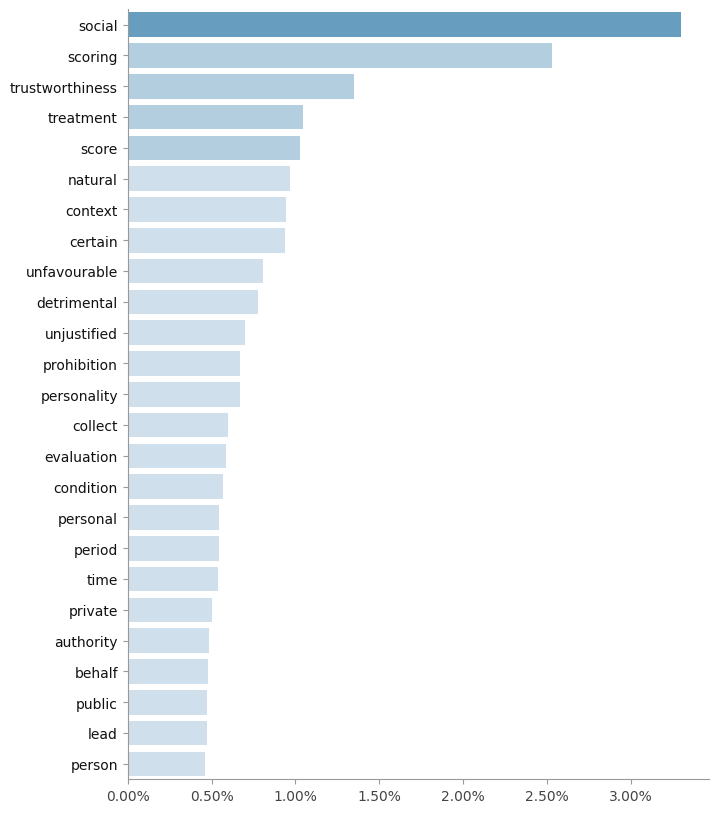

In [24]:
fig, _ = evaluation.plot_topic_terms(lda_pipeline, 0, n_terms=25)
fig.show()

# ATP: Association of Test Publishers
# fmt: off
lda_topic_names = [
    "Social scoring",
    "AIaaS",
    "Protecting fundamental rights",
    "Education",
    "Healthcare",
    "Protecting children",
    "Biometrics",
    "Cover pages",
    "Interpretability",
    "Medical devices",
    "Creditworthiness scoring",
    "Automobiles",
    "Data & biases",
    "Manipulative influences",
    "Data protections",
    "Regulation costs and innovation",
    "National Competent Authorities",
    "High-risk AI (regulation)",
    "Children & technology design",
    "AI Act (legislative process)",
]

In [25]:
for i in range(lda_pipeline.named_steps["topic_model"].n_components):
    fig, ax = evaluation.plot_topic_terms(lda_pipeline, i, n_terms=15)
    if len(lda_topic_names) > i:
        ax.set_title(f"Topic '{lda_topic_names[i]}'")
    fig.savefig(f"images/lda_topic_{str(i).zfill(2)}.pdf", bbox_inches="tight")
    plt.close(fig)
evaluation.merge_pdfs(
    sorted(
        ["images/" + f for f in os.listdir("images/") if f.startswith("lda_topic_")]
    ),
    "images/lda_topics.pdf",
)

### Topics to user types

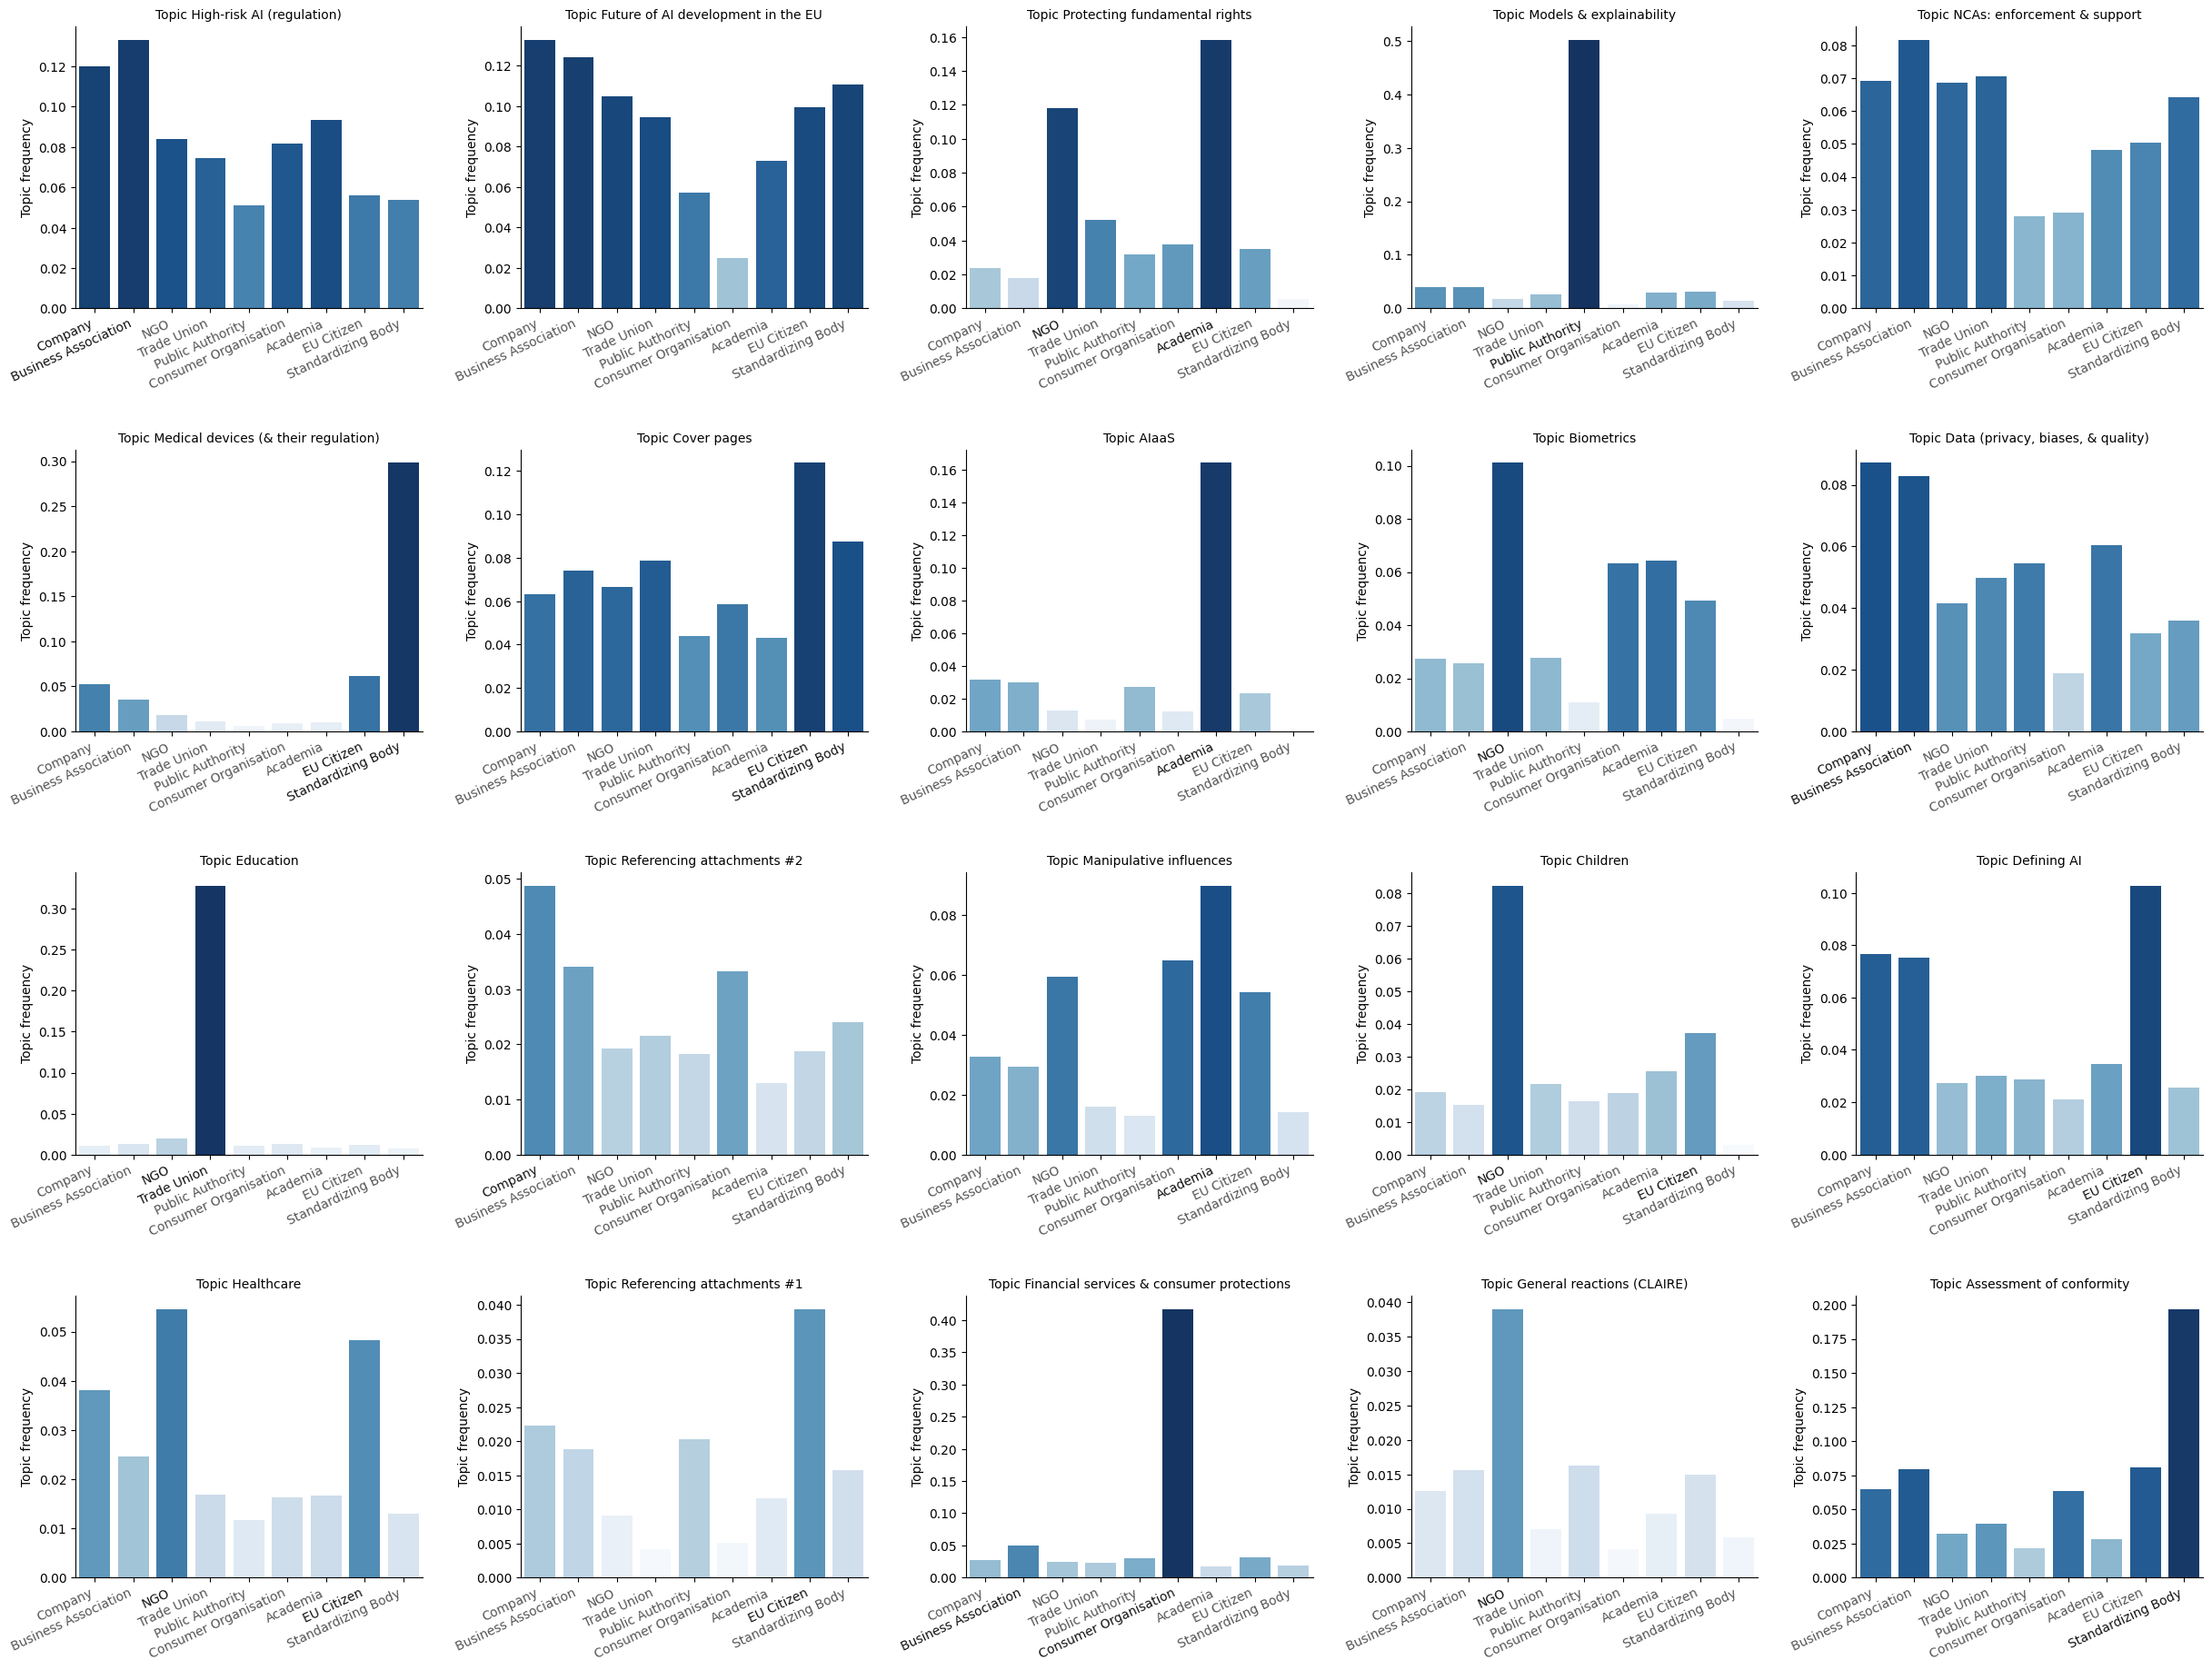

In [26]:
g = evaluation.plot_topics_to_user_types(df, H_nmf, topic_names=nmf_topic_names)

g.fig.savefig("images/topics_to_user_types.pdf", bbox_inches="tight")

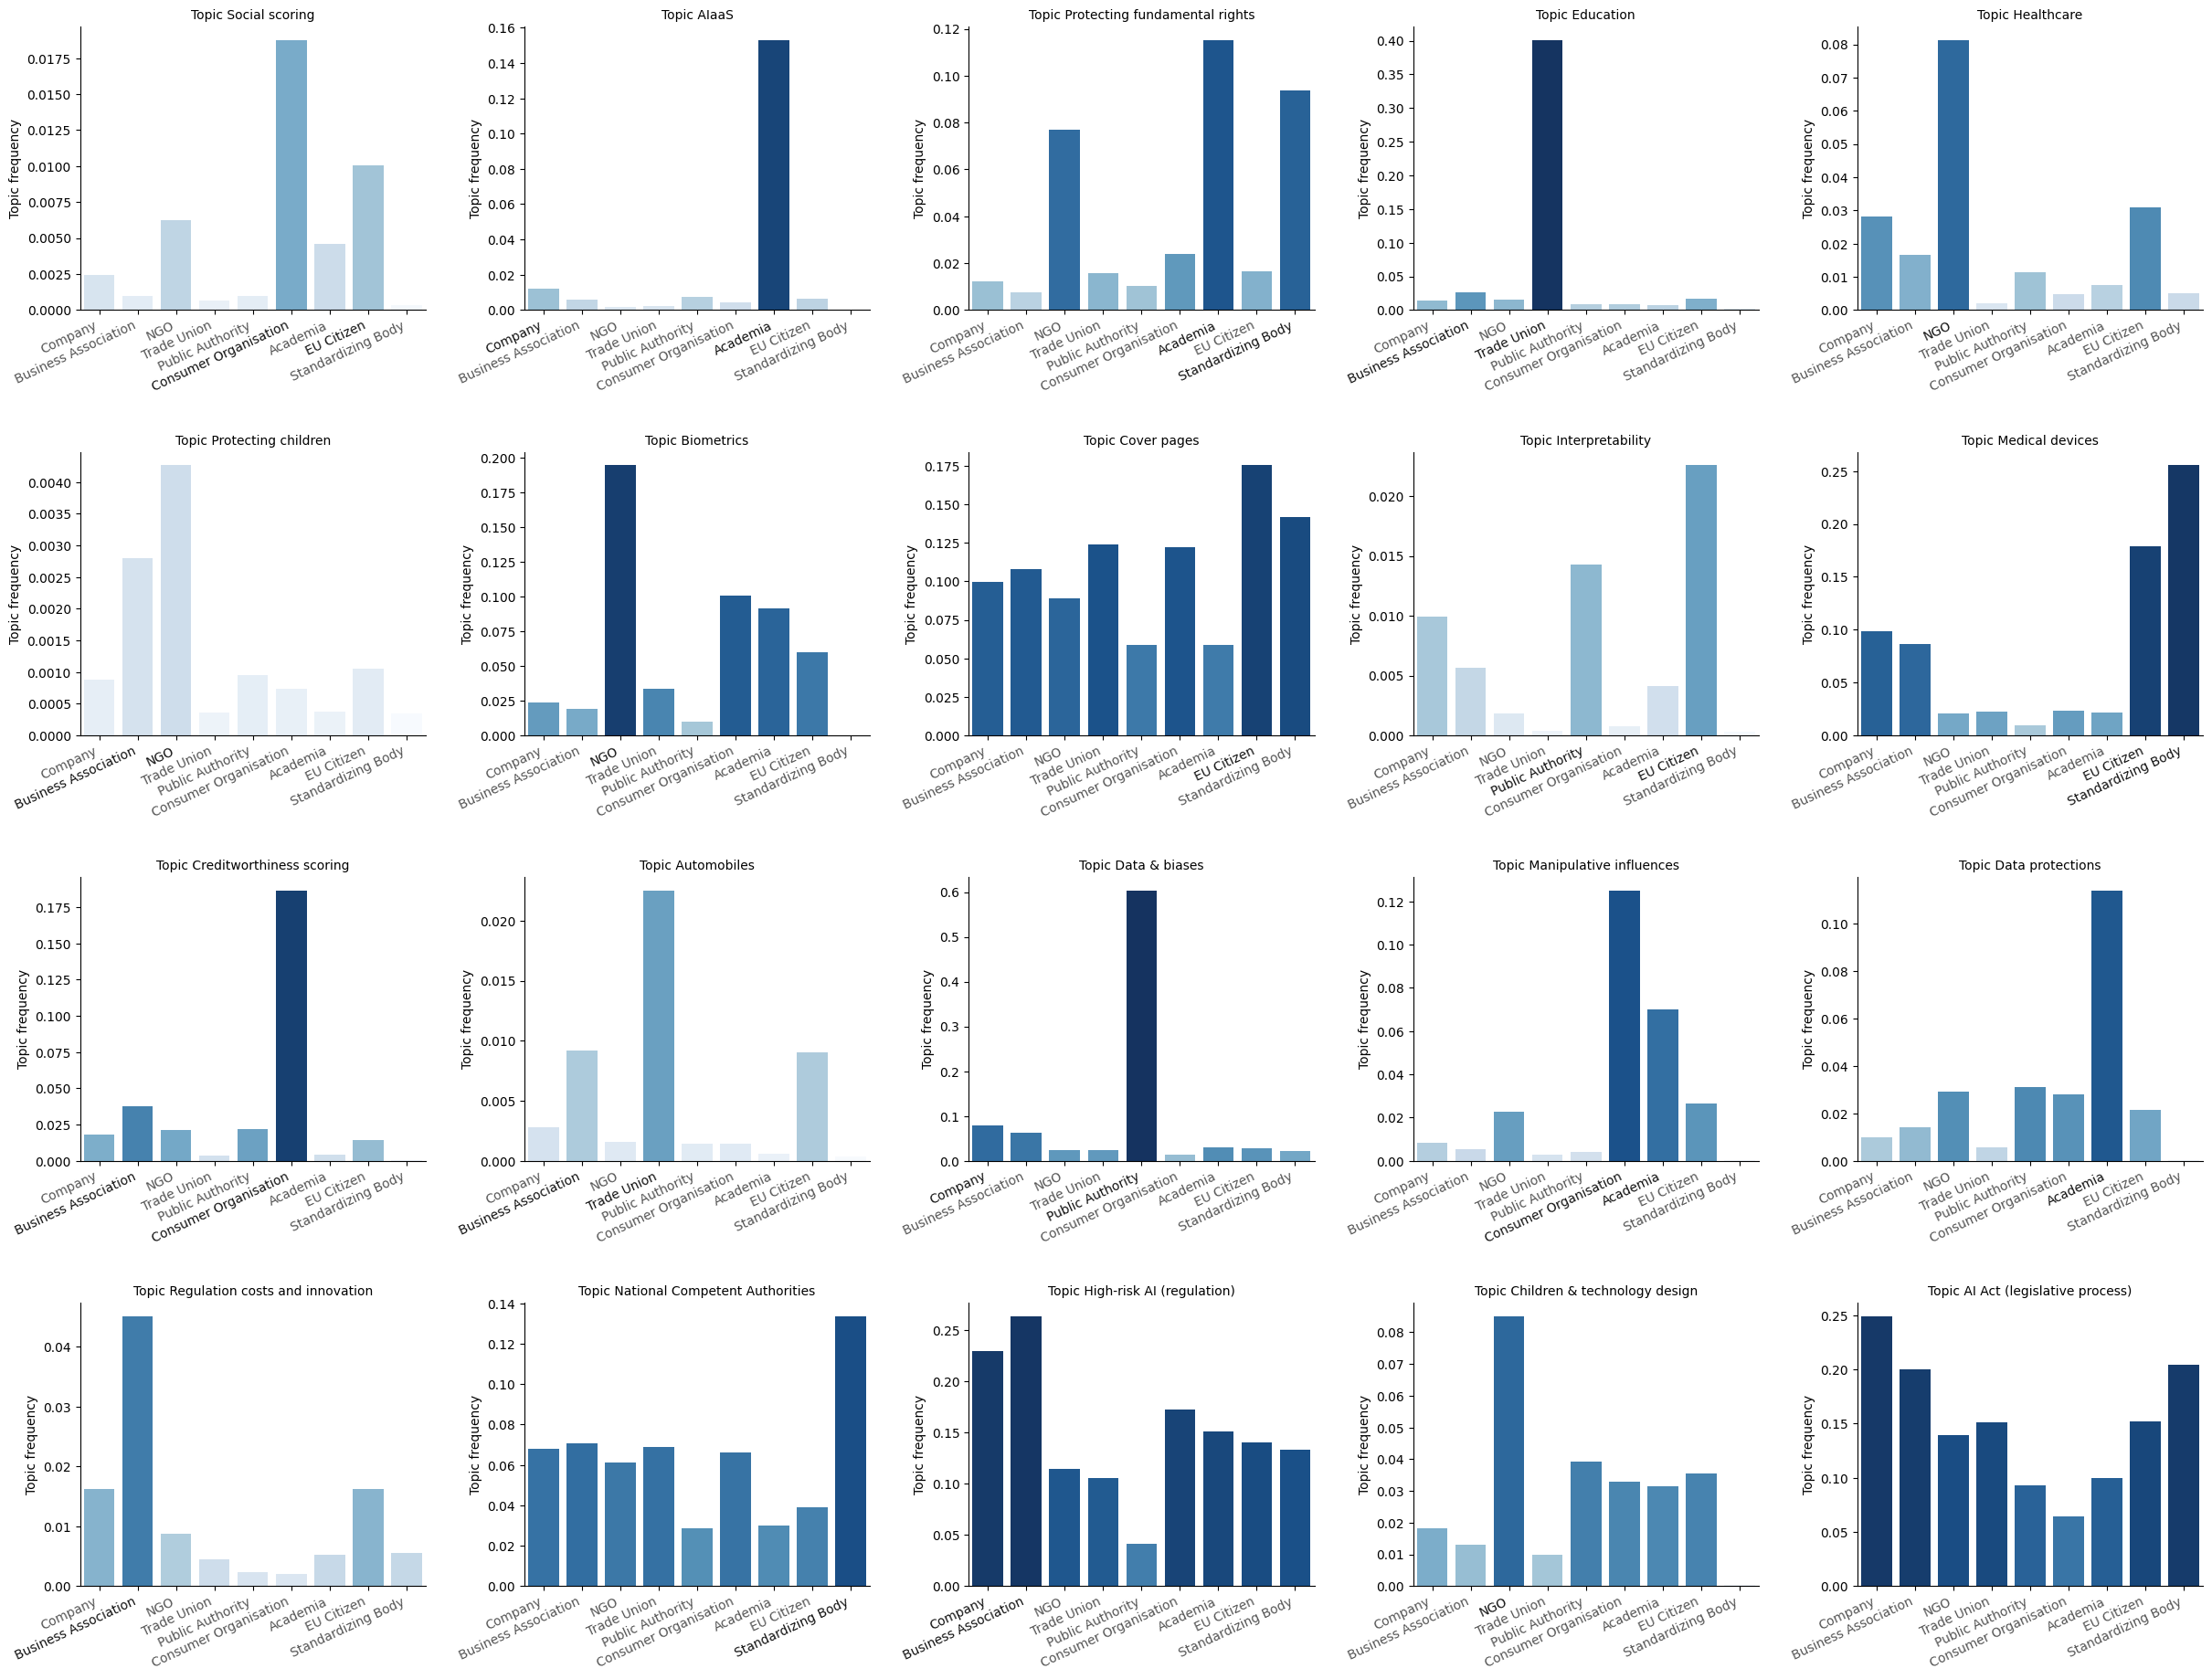

In [27]:
g = evaluation.plot_topics_to_user_types(df, H_lda, topic_names=lda_topic_names)

g.fig.savefig("images/topics_to_user_types_lda.pdf", bbox_inches="tight")

### User types to topics

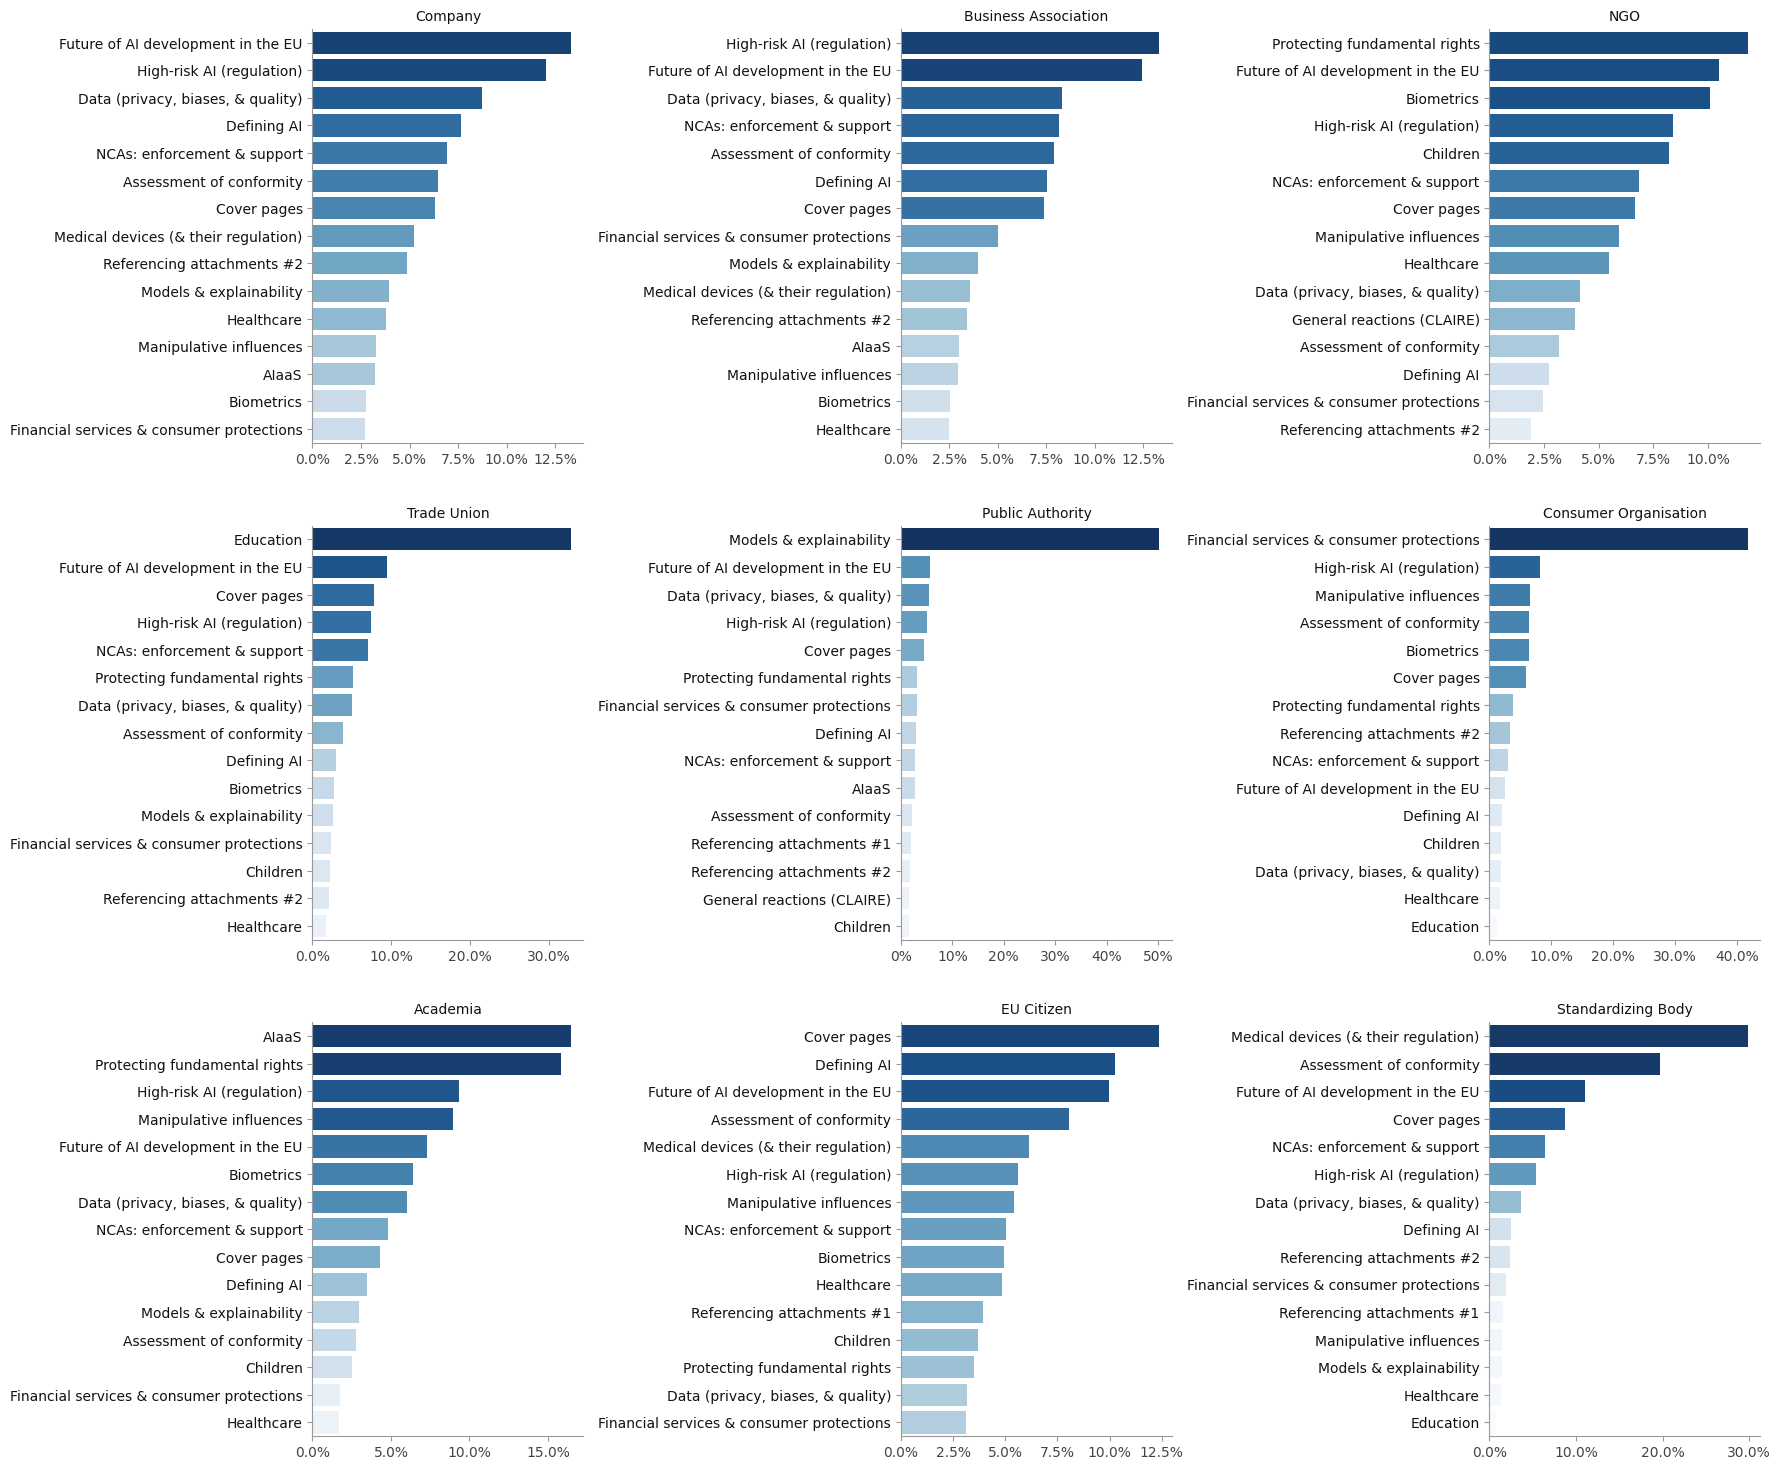

In [28]:
g = evaluation.plot_user_types_to_topics(df, H_nmf, nmf_topic_names, top_n=15)
g.fig.savefig("images/user_types_to_topics.pdf", bbox_inches="tight")

In [29]:
import IPython


def print_topic_examples(df, H, topic_names, topic, user_type):
    df = evaluation.examples_for(df, H, topic_names, topic, user_type)

    for i, (_, row) in enumerate(df.iterrows()):
        IPython.display.clear_output()
        print(
            row.id,
            row.organization,
            row.country,
            round(row[topic], 2),
            f"{str(i).rjust(len(str(len(df))))}/{len(df)}\n",
        )
        print(row.text)
        import sys

        sys.stdout.flush()
        if input("Continue? y/N") in ["", "n", "N"]:
            break


# print_topic_examples(df, H_nmf, nmf_topic_names, "High risk AI", "eu_citizen")

## Chunking strategy

### Reading in the dataset with different chunking strategies

In [30]:
doc_df = pd.read_csv(
    "../24212003_requirements_for_artificial_intelligence/patched_feedbacks.csv"
)
dataloader = Dataloader("document")
doc_df = dataloader.from_folder(
    "../24212003_requirements_for_artificial_intelligence/attachments/", doc_df
)
doc_df.head()

As n_jobs=-1 <= 0, enabling multiprocessing with 24 cores!
As n_jobs=-1 <= 0, enabling multiprocessing with 24 cores!


,id,text,language,country,user_type,organization,surname,feedback,status,company_size,...,publication,publication_id,publication_status,tr_number,scope,governance_level,full_name,source,language_detected,tokenized
0,2665651,Equinet welcomes the opportunity to provide co...,en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,anonymous,24212003,closed,NaN,NaN,NaN,NaN,attachment,en,"[equinet, welcome, the, opportunity, to, provi..."
1,2665650,AI Austria welcomes the opportunity to comment...,en,AUT,ngo,AI Austria,Gorzala,AI Austria welcomes the opportunity to comment...,PUBLISHED,small,...,withinfo,24212003,closed,NaN,NaN,NaN,Jeannette Gorzala,attachment,en,"[ai, austria, welcome, the, opportunity, to, c..."
2,2665649,This submission to the AIA consultation is sen...,en,DEU,ngo,Digitalcourage e.V.,NaN,This submission to the AIA consultation is sen...,PUBLISHED,small,...,anonymous,24212003,closed,NaN,NaN,NaN,NaN,attachment,en,"[this, submission, to, the, aia, consultation,..."
3,2665648,The EU AI Act is an important step in the righ...,en,USA,academic_research_institution,UC Berkeley Center for Human-Compatible AI,NaN,The EU AI Act is an important step in the righ...,PUBLISHED,small,...,anonymous,24212003,closed,NaN,NaN,NaN,NaN,attachment,en,"[the, eu, ai, act, be, an, important, step, in..."
4,2665647,In response to the European Commission’s reque...,en,USA,company,CrowdStrike,NaN,In response to the European Commission’s reque...,PUBLISHED,large,...,anonymous,24212003,closed,NaN,NaN,NaN,NaN,attachment,en,"[in, response, to, the, european, commission, ..."


In [31]:
doc_df = doc_df.query("language_detected == 'en' and tokenized.str.len() > 0").copy()

nmf_doc_topic = topic_models.hyperparameter_tune(doc_df, nmf_pipeline, "nmf_doc_topics")

Existing hyperparameter tuning for pipeline nmf_doc_topics found, continuing there. You can force the use your (or the default) hyperparameter by setting overwrite=True.


  0%|          | 0/15 [00:00<?, ?it/s]

In [32]:
line_df = pd.read_csv(
    "../24212003_requirements_for_artificial_intelligence/patched_feedbacks.csv"
)
line_df = Dataloader("line").from_folder(
    "../24212003_requirements_for_artificial_intelligence/attachments/", line_df
)
line_df.head()

As n_jobs=-1 <= 0, enabling multiprocessing with 24 cores!
As n_jobs=-1 <= 0, enabling multiprocessing with 24 cores!


,id,text,language,country,user_type,organization,surname,feedback,status,company_size,...,publication,publication_id,publication_status,tr_number,scope,governance_level,full_name,source,language_detected,tokenized
0,2665651,Equinet welcomes the opportunity to provide co...,en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,anonymous,24212003,closed,NaN,NaN,NaN,NaN,attachment,en,"[equinet, welcome, the, opportunity, to, provi..."
1,2665651,Equality is explicitly and prominently address...,en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,anonymous,24212003,closed,NaN,NaN,NaN,NaN,attachment,en,"[equality, be, explicitly, and, prominently, a..."
2,2665651,Please find as an attachment the following key...,en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,anonymous,24212003,closed,NaN,NaN,NaN,NaN,attachment,en,"[please, find, as, an, attachment, the, follow..."
3,2665651,Equinet’s feedback to the European Commission'...,en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,anonymous,24212003,closed,NaN,NaN,NaN,NaN,attachment,en,"[equinet, feedback, to, the, european, commiss..."
4,2665651,on Artificial Intelligence (AI) Systems,en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,anonymous,24212003,closed,NaN,NaN,NaN,NaN,attachment,en,"[on, artificial, intelligence, ai, systems]"


In [33]:
line_df = line_df.query("language_detected == 'en' and tokenized.str.len() > 0").copy()

nmf_line_topic = topic_models.hyperparameter_tune(
    line_df, nmf_pipeline, "nmf_line_topics"
)

Existing hyperparameter tuning for pipeline nmf_line_topics found, continuing there. You can force the use your (or the default) hyperparameter by setting overwrite=True.


  0%|          | 0/15 [00:00<?, ?it/s]

In [34]:
sent_df = pd.read_csv(
    "../24212003_requirements_for_artificial_intelligence/patched_feedbacks.csv"
)
sent_df = Dataloader("sentence").from_folder(
    "../24212003_requirements_for_artificial_intelligence/attachments/", sent_df
)
sent_df.head()

As n_jobs=-1 <= 0, enabling multiprocessing with 24 cores!
As n_jobs=-1 <= 0, enabling multiprocessing with 24 cores!
As n_jobs=-1 <= 0, enabling multiprocessing with 24 cores!


,id,text,language,country,user_type,organization,surname,feedback,status,company_size,...,publication,publication_id,publication_status,tr_number,scope,governance_level,full_name,source,language_detected,tokenized
0,2665651,Equinet welcomes the opportunity to provide co...,en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,anonymous,24212003,closed,NaN,NaN,NaN,NaN,attachment,en,"[equinet, welcome, the, opportunity, to, provi..."
1,2665651,Equinet further wishes to reiterate its suppor...,en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,anonymous,24212003,closed,NaN,NaN,NaN,NaN,attachment,en,"[equinet, far, wish, to, reiterate, its, suppo..."
2,2665651,Equality is explicitly and prominently address...,en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,anonymous,24212003,closed,NaN,NaN,NaN,NaN,attachment,en,"[equality, be, explicitly, and, prominently, a..."
3,2665651,"Yet, the current text of the Proposal for an A...",en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,anonymous,24212003,closed,NaN,NaN,NaN,NaN,attachment,en,"[yet, the, current, text, of, the, proposal, f..."
4,2665651,Please find as an attachment the following key...,en,BEL,ngo,Equinet,NaN,Equinet welcomes the opportunity to provide co...,PUBLISHED,micro,...,anonymous,24212003,closed,NaN,NaN,NaN,NaN,attachment,en,"[please, find, as, an, attachment, the, follow..."


In [35]:
sent_df = sent_df.query("language_detected == 'en' and tokenized.str.len() > 0").copy()

nmf_sent_topic = topic_models.hyperparameter_tune(
    sent_df, nmf_pipeline, "nmf_sent_topics"
)

Existing hyperparameter tuning for pipeline nmf_sent_topics found, continuing there. You can force the use your (or the default) hyperparameter by setting overwrite=True.


  0%|          | 0/15 [00:00<?, ?it/s]

### Comparing results

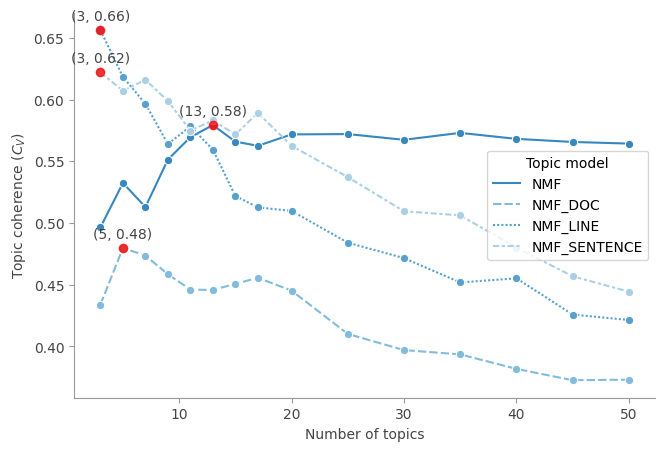

In [36]:
nmf_doc_topic["topic_model"] = "nmf_doc"
nmf_line_topic["topic_model"] = "nmf_line"
nmf_sent_topic["topic_model"] = "nmf_sentence"
hyperparameters = pd.concat((nmf_topic, nmf_doc_topic, nmf_line_topic, nmf_sent_topic))
hyperparameters["score"] = hyperparameters["score"].astype("float")

fig, _ = evaluation.plot_coherence_against_topics(hyperparameters)

fig.savefig("images/coherence_against_topics_extended.pdf", bbox_inches="tight")

#### Results at the highest topic coherence

In [37]:
nmf_pipeline, H = topic_models.trained_pipeline_from_hyperparameters(
    nmf_pipeline, nmf_doc_topic, doc_df, 5
)

evaluation.get_topics_from_pipeline(nmf_pipeline)

,topic_00,topic_01,topic_02,topic_03,topic_04
0,ai,healthcare,right,medical,education
1,risk,ai,biometric,device,intelligence
2,use,patient,use,mdr,artificial
3,regulation,health,law,aia,tool
4,high,datum,fundamental,ivdr,ai
5,requirement,professional,aia,manufacturer,european
6,act,use,risk,requirement,personnel
7,article,medical,person,risk,regulation
8,definition,ensure,human,regulation,student
9,commission,european,recognition,article,academic


In [38]:
nmf_pipeline, H = topic_models.trained_pipeline_from_hyperparameters(
    nmf_pipeline, nmf_sent_topic, sent_df, 3
)

evaluation.get_topics_from_pipeline(nmf_pipeline)

,topic_00,topic_01,topic_02
0,ai,intelligence,datum
1,risk,artificial,use
2,high,european,data
3,use,commission,protection
4,requirement,proposal,right
5,regulation,regulation,gdpr
6,application,act,personal
7,definition,eu,processing
8,assessment,welcome,model
9,article,2021,biometric


In [39]:
nmf_pipeline, H = topic_models.trained_pipeline_from_hyperparameters(
    nmf_pipeline, nmf_line_topic, line_df, 3
)

evaluation.get_topics_from_pipeline(nmf_pipeline)

,topic_00,topic_01,topic_02
0,ai,risk,intelligence
1,use,high,artificial
2,datum,requirement,regulation
3,provider,assessment,european
4,definition,base,act
5,act,approach,commission
6,user,list,proposal
7,regulation,consider,propose
8,article,management,eu
9,application,iii,rule


#### Results at 20 topics

In [40]:
nmf_pipeline, H = topic_models.trained_pipeline_from_hyperparameters(
    nmf_pipeline, nmf_doc_topic, doc_df, 20
)

evaluation.get_topics_from_pipeline(nmf_pipeline)

,topic_00,topic_01,topic_02,topic_03,topic_04,topic_05,topic_06,topic_07,topic_08,topic_09,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,ai,healthcare,right,medical,education,credit,aia,standard,datum,provider,article,artificial,consumer,sme,child,insurance,worker,vehicle,assessment,test
1,risk,patient,biometric,device,ai,financial,ai,standardisation,data,risk,ai,intelligence,ai,cost,online,risk,workplace,sweden,conformity,testing
2,use,ai,law,mdr,tool,creditworthiness,startup,regulation,use,user,shall,act,art,regulation,technology,regulation,employee,automotive,ex,use
3,act,health,use,ivdr,personnel,risk,intelligence,european,model,obligation,datum,european,product,startup,use,definition,employment,o,ai,organization
4,high,professional,fundamental,manufacturer,student,regulation,artificial,standardization,processing,requirement,annex,use,risk,certification,young,oecd,regulation,manufacturer,notify,decision
5,definition,ensure,risk,regulation,european,use,sandbox,commission,algorithm,provide,risk,commission,application,company,sexual,propose,labour,maintenance,body,analysis
6,eu,medical,enforcement,risk,academic,score,technology,nlf,ml,high,regulation,risk,use,sandbox,digital,framework,collective,car,european,automate
7,regulation,european,human,software,intelligence,institution,ec,specification,gdpr,deployer,use,believe,harm,innovation,social,company,o,european,ante,score
8,technology,care,emotion,requirement,artificial,service,requirement,product,process,article,person,create,legislation,application,abuse,approach,job,regulation,independent,scoring
9,approach,need,person,notified,regulation,banking,human,ec,quality,market,high,definition,high,european,protect,commission,work,act,company,computer


In [41]:
nmf_pipeline, H = topic_models.trained_pipeline_from_hyperparameters(
    nmf_pipeline, nmf_sent_topic, sent_df, 20
)

evaluation.get_topics_from_pipeline(nmf_pipeline)

,topic_00,topic_01,topic_02,topic_03,topic_04,topic_05,topic_06,topic_07,topic_08,topic_09,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,risk,intelligence,datum,right,set,article,use,regulation,art,authority,provider,approach,assessment,requirement,definition,biometric,human,ai,act,data
1,high,artificial,personal,fundamental,error,proposal,case,propose,gdpr,market,user,base,conformity,transparency,scope,identification,decision,technology,ai,protection
2,ai,european,processing,impact,free,3,ai,draft,state,public,obligation,product,impact,standard,broad,remote,make,development,draft,gdpr
3,application,commission,model,safety,complete,1,purpose,eu,accord,national,service,annex,party,device,ai,time,oversight,eu,propose,general
4,iii,proposal,process,individual,training,5,person,exist,iii,access,ai,learning,procedure,need,software,real,ai,regulatory,delegate,governance
5,consider,2021,quality,protect,testing,2,intend,scope,1,member,customer,technique,self,compliance,3,recognition,process,innovation,legislation,european
6,low,welcome,access,harm,validation,annex,specific,medical,propose,surveillance,responsibility,include,body,medical,technique,law,making,framework,adopt,law
7,list,lay,bias,health,relevant,title,context,specific,9,service,information,machine,require,technical,clear,enforcement,automate,support,comment,board
8,management,council,subject,freedom,representative,iii,example,device,title,competent,aiaas,list,notify,specific,annex,space,algorithm,sandbox,feedback,processing
9,classification,parliament,collect,protection,shall,10,prohibit,ai,5,supervisory,end,method,ex,exist,define,emotion,transparency,europe,legislative,privacy


In [42]:
nmf_pipeline, H = topic_models.trained_pipeline_from_hyperparameters(
    nmf_pipeline, nmf_line_topic, line_df, 20
)

evaluation.get_topics_from_pipeline(nmf_pipeline)

,topic_00,topic_01,topic_02,topic_03,topic_04,topic_05,topic_06,topic_07,topic_08,topic_09,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,ai,risk,intelligence,human,use,right,datum,european,article,assessment,requirement,provider,technology,authority,act,approach,market,biometric,eu,include
1,regulation,high,artificial,oversight,case,fundamental,personal,commission,3,conformity,set,user,make,public,propose,base,service,identification,protection,application
2,definition,consider,regulation,14,intend,impact,processing,proposal,5,impact,transparency,obligation,decision,national,intelligence,risk,product,time,data,annex
3,development,management,propose,right,purpose,safety,access,parliament,definition,party,compliance,information,development,enforcement,legislative,technique,definition,remote,law,list
4,develop,classification,rule,rights,model,protect,training,welcome,1,procedure,chapter,responsibility,process,law,scope,statistical,safety,real,gdpr,iii
5,trustworthy,level,lay,define,context,freedom,subject,union,10,self,legal,transparency,need,competent,draft,learning,place,person,regulation,scope
6,propose,pose,harmonise,ensure,example,health,set,council,2,require,technical,customer,regulatory,member,amend,welcome,component,recognition,general,area
7,high,low,draft,objective,prohibit,individual,quality,provide,9,body,2,end,framework,supervisory,delegate,machine,health,natural,governance,ii
8,deploy,category,proposal,transparency,specific,respect,process,board,gdpr,process,title,provide,new,purpose,proposal,knowledge,surveillance,categorisation,level,technique
9,solution,classify,council,feature,law,privacy,model,feedback,52,ex,comply,purpose,standard,surveillance,certain,support,legislation,emotion,ensure,1


## Exporting for in-depth analysis

In [43]:
nmf_pipeline, H_nmf = topic_models.trained_pipeline_from_hyperparameters(
    nmf_pipeline, nmf_topic, df, 20
)

evaluation.export_for_indepth_analysis(
    "../06_explorer/explorer/data/nmf_page", df, nmf_pipeline, H_nmf, nmf_topic_names
)

/home/felix/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/felix/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/felix/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/felix/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentatio

In [44]:
lda_pipeline, H_lda = topic_models.trained_pipeline_from_hyperparameters(
    lda_pipeline, lda_topic, df, 20
)

evaluation.export_for_indepth_analysis(
    "../06_explorer/explorer/data/lda_page", df, lda_pipeline, H_lda, lda_topic_names
)

/home/felix/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/felix/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/felix/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/felix/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentatio

## PyLDAvis

In [45]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [46]:
vectorizer = nmf_pipeline.named_steps["vectorizer"]
vectorized = vectorizer.transform(df["tokenized"])
topic_model = nmf_pipeline.named_steps["topic_model"]
pyLDAvis.sklearn.prepare(topic_model, vectorized, vectorizer)

/home/felix/.local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/felix/.local/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/felix/.local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/felix/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/felix/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.062820 -0.024149       1        1  10.903409
0     -0.105657 -0.105974       2        1  10.643881
2     -0.077832  0.148405       3        1   7.263008
9     -0.126444 -0.058550       4        1   6.908276
4     -0.071486 -0.109458       5        1   6.906567
14    -0.061592 -0.116307       6        1   5.830862
19    -0.037576 -0.221670       7        1   5.669618
8     -0.121847  0.119299       8        1   5.597061
6      0.219489  0.025390       9        1   5.565216
3     -0.097619 -0.006037      10        1   5.355590
12    -0.110989  0.111462      11        1   4.732370
7     -0.095706  0.050217      12        1   4.284580
17    -0.057379  0.061253      13        1   3.804308
15    -0.029967  0.022345      14        1   3.595544
13    -0.039795  0.173921      15        1   3.506213
5     -0.019397 -0.229669      16        1   3.229011
10     0.009687  0.115284      17        1   2.075263
18     0.077646  0.054476      18        1   1.633238
11     0.381310  0.013928      19        1   1.615994
16     0.302335 -0.024165      20        1   0.879992, topic_info=              Term       Freq      Total Category  logprob  loglift
384       attached  54.000000  54.000000  Default  30.0000  30.0000
383         attach  61.000000  61.000000  Default  29.0000  29.0000
356     artificial  76.000000  76.000000  Default  28.0000  28.0000
1735  intelligence  77.000000  77.000000  Default  27.0000  27.0000
1359      feedback  48.000000  48.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
2975    suggestion   0.495258   8.070195  Topic20  -5.9206   1.9422
1875   legislation   0.603105  30.140685  Topic20  -5.7236   0.8215
2475       propose   0.629733  48.036435  Topic20  -5.6804   0.3986
2013        member   0.564310  28.246677  Topic20  -5.7901   0.8199
2168         offer   0.535904  15.450379  Topic20  -5.8417   1.3716

[1109 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         9  0.732947      +49
2         1  0.034236        1
2         3  0.068473        1
2         4  0.068473        1
2         6  0.171181        1
...     ...       ...      ...
3347     15  0.330619     year
3347     16  0.082655     year
3350     15  1.039401    young
3351     15  1.116934    youth
3352     15  0.808268  youtube

[2917 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 10, 5, 15, 20, 9, 7, 4, 13, 8, 18, 16, 14, 6, 11, 19, 12, 17])

In [47]:
vectorizer = lda_pipeline.named_steps["vectorizer"]
vectorized = vectorizer.transform(df["tokenized"])
topic_model = lda_pipeline.named_steps["topic_model"]
pyLDAvis.sklearn.prepare(topic_model, vectorized, vectorizer)

/home/felix/.local/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/felix/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/felix/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/felix/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's docume

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.174159 -0.067354       1        1  19.712227
19     0.156938  0.080629       2        1  16.980617
6      0.074296 -0.108902       3        1   8.697275
12     0.034678 -0.091106       4        1   7.905510
9      0.118186  0.018423       5        1   6.627811
16     0.101691  0.028538       6        1   6.102052
7      0.046717  0.249189       7        1   4.980790
2      0.088376  0.007102       8        1   4.824218
14     0.022514 -0.101101       9        1   4.585049
4      0.048023  0.067757      10        1   3.706859
18    -0.116688  0.009933      11        1   3.301900
3      0.039611  0.003222      12        1   2.828707
1     -0.010260 -0.087943      13        1   2.627171
13    -0.018516 -0.081577      14        1   2.251784
10    -0.046093 -0.024972      15        1   2.164578
15    -0.067902  0.061074      16        1   1.709229
0     -0.154340 -0.023558      17        1   0.350491
11    -0.171926  0.023591      18        1   0.348194
8     -0.164633  0.023158      19        1   0.147933
5     -0.154833  0.013898      20        1   0.147605, topic_info=              Term          Freq         Total Category  logprob  loglift
258             ai  17047.000000  17047.000000  Default  30.0000  30.0000
2702         right   3133.000000   3133.000000  Default  29.0000  29.0000
1735  intelligence   1856.000000   1856.000000  Default  28.0000  28.0000
356     artificial   1801.000000   1801.000000  Default  27.0000  27.0000
893          datum   3754.000000   3754.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
2422       privacy      1.728553    441.154170  Topic20  -6.0047   0.9763
3090          tool      1.667425    582.456947  Topic20  -6.0407   0.6624
3119  transparency      1.648096    934.838002  Topic20  -6.0524   0.1776
3330          work      1.573393    752.339185  Topic20  -6.0988   0.3484
2483    protection      1.616267   1285.888151  Topic20  -6.0719  -0.1607

[1170 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         2  0.030946         +32
0         7  0.742692         +32
0        10  0.030946         +32
0        12  0.030946         +32
1         1  0.036093         +49
...     ...       ...         ...
3354      8  0.524748  zuiderveen
3354      9  0.024988  zuiderveen
3354     11  0.024988  zuiderveen
3354     13  0.024988  zuiderveen
3354     14  0.099952  zuiderveen

[10077 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 20, 7, 13, 10, 17, 8, 3, 15, 5, 19, 4, 2, 14, 11, 16, 1, 12, 9, 6])